In [1]:
from sklearn.datasets import fetch_openml
dataset = fetch_openml("mnist_784")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import scipy
import cv2 as cv
import seaborn as sns

In [2]:
features = dataset.data.to_numpy()
target = dataset.target.to_numpy()

In [3]:
from sklearn.model_selection import train_test_split
X_train = features[:60000]
X_test = features[60000:70000]
y_train = target[:60000]
y_test = target[60000:70000]

In [4]:
def euclidean_distance(X, Y):
    X_norms_square = np.linalg.norm(X, axis=1) ** 2
    Y_norms_square = np.linalg.norm(Y, axis=1) ** 2
    euclidean_distance_matrix = np.sqrt(X_norms_square.reshape(X.shape[0], 1) +
                                        Y_norms_square.reshape(1, Y.shape[0]) - 2 * X @ Y.T)
    return euclidean_distance_matrix


def cosine_distance(X, Y):
    X_norms = np.linalg.norm(X, axis=1)
    Y_norms = np.linalg.norm(Y, axis=1)
    # transpose for broadcasting
    X_transposed_and_normalized = X.T / np.where(X_norms != 0, X_norms, 1)
    Y_transposed_and_normalized = Y.T / np.where(Y_norms != 0, Y_norms, 1)
    cosine_distance_matrix = X_transposed_and_normalized.T @ Y_transposed_and_normalized
    return 1 - cosine_distance_matrix


In [5]:
class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size
        self.X_samples = None
        self.y_samples = None
        self.NN_model = None
        if self.strategy in ['kd_tree', 'ball_tree', 'brute']:
          self.NN_model = NearestNeighbors(n_neighbors=self.k,
                                         algorithm=self.strategy,
                                         metric=self.metric)

    def fit(self, X, y):
        self.X_samples = X
        self.y_samples = y
        if self.strategy in ['kd_tree', 'ball_tree', 'brute']:
          self.NN_model.fit(X, y)

    def my_own_find_kneighbors(self, X, k, return_distance):
        if self.metric == 'cosine':
            distance_function = cosine_distance
        else:
            distance_function = euclidean_distance

        distances_matrix = distance_function(X, self.X_samples)
        indices = np.argpartition(distances_matrix, kth=np.arange(k),
                                  axis=1)[:, :k]
        distances = np.take_along_axis(distances_matrix, indices, axis=1)
        if return_distance is False:
            return indices
        return distances, indices

    def find_kneighbors(self, X, return_distance):
        if self.metric == 'cosine':
            distance_function = cosine_distance
        else:
            distance_function = euclidean_distance

        if self.strategy == 'my_own':
            find_function = self.my_own_find_kneighbors
        else:
            find_function = self.NN_model.kneighbors


        if self.test_block_size and X.shape[0] > self.test_block_size:
            num_blocks = X.shape[0] // self.test_block_size
            X_sections = np.array_split(X, num_blocks)
            if return_distance:
                distances, indices = find_function(X_sections[0], self.k, True)
                for section in X_sections[1:]:
                    distance, index = find_function(section, self.k, True)
                    indices = np.vstack((indices, index))
                    distances = np.vstack((distances, distance))
                return distances, indices

            else:
                indices = find_function(X_sections[0], self.k, False)
                for section in X_sections[1:]:
                    index = find_function(section, self.k, False)
                    indices = np.vstack((indices, index))
                return indices
        else:
            return find_function(X, self.k, return_distance)

    def predict(self, X):
        eps = 10 ** (-5)
        distances, indices = self.find_kneighbors(X, return_distance=True)
        if not self.weights:
            weights = np.ones_like(distances)
        else:
            weights = 1 / (distances + eps)

        targets = self.y_samples[indices]
        unique_targets = np.unique(targets)
        weighted_targets = np.array([])
        for index in range(len(unique_targets)):
            target = unique_targets[index]
            only_target = np.where(targets == target, 1, 0)
            weighted_target = np.sum(weights * only_target, axis=1)
            weighted_target = weighted_target.reshape((len(weighted_target), 1))
            if index == 0:
                weighted_targets = weighted_target
            else:
                weighted_targets = np.hstack((weighted_targets, weighted_target))
        max_indices = np.argmax(weighted_targets, axis=1)
        return unique_targets[max_indices]


In [6]:
def kfold(n, n_folds):
    indices = np.arange(n)
    split = np.array_split(indices, n_folds)
    cv = list()
    for i in range(n_folds):
        cv.append((np.hstack(split[:i] + split[i+1:]), split[i]))
    return cv


def predict_with_distance(knn_model, y, distances, indices):
    eps = 10 ** (-5)
    if not knn_model.weights:
        weights = np.ones_like(distances)
    else:
        weights = 1 / (distances + eps)

    targets = y[indices]
    unique_targets = np.unique(y[indices])
    weighted_targets = np.array([])
    for index in range(len(unique_targets)):
        target = unique_targets[index]
        only_target = np.where(targets == target, 1, 0)
        weighted_target = np.sum(weights * only_target, axis=1)
        weighted_target = weighted_target.reshape((len(weighted_target), 1))
        if index == 0:
            weighted_targets = weighted_target
        else:
            weighted_targets = np.hstack((weighted_targets, weighted_target))
    max_indices = np.argmax(weighted_targets, axis=1)
    return unique_targets[max_indices]


def knn_cross_val_score(X, y, k_list, score, cv, **kwargs):
    k_dict = {}
    if cv is None:
        cv = kfold(X.shape[0], 3)

    k_max = k_list[-1]
    knn_model = KNNClassifier(k_max, **kwargs)
    for train, valid in cv:
        knn_model.fit(X[train], y[train])
        distances, indices = knn_model.find_kneighbors(X[valid], return_distance=True)
        for k in k_list:
            if k not in k_dict.keys():
                k_dict[k] = np.array([])
            y_predict = predict_with_distance(knn_model, y[train],
                                              distances[:, :k], indices[:, :k])
            if score == 'accuracy':
                ans_num = y[valid].shape[0]
                true_ans_num = np.sum(y[valid] == y_predict)
                k_dict[k] = np.append(k_dict[k], true_ans_num / ans_num)
    return k_dict

# Эксперимент №1

Исследуйте, какой алгоритм поиска ближайших соседей будет быстрее работать в различных ситуациях и
почему.

Измерьте для каждого алгоритма поиска ('kd_tree', 'ball_tree', 'brute' и 'my_own') время нахождения 5
ближайших соседей для каждого объекта тестовой выборки по евклидовой метрике. Выберите подмножество признаков, по которому будет считаться расстояние, размера 10, 20, 100 (подмножество признаков
выбирается один раз для всех объектов, случайно). Проверьте все алгоритмы поиска ближайших соседей,
указанные в спецификации к заданию.

In [105]:
np.random.seed(10)
indices = np.arange(X_train.shape[1])
features_indices = [np.random.choice(indices, n) for n in [10, 20, 100]]
features_indices

[array([265, 125, 527, 320, 369, 123, 156, 733, 496,   8]),
 array([ 73, 256, 490,  40, 502, 420, 371, 528, 356, 239, 395,  54, 344,
        363, 122, 574, 545, 200, 689, 691]),
 array([ 54,  77, 453,  13, 755, 409, 382, 653, 342, 670,  89, 652, 321,
        543, 283, 530,  93,  77, 406, 606, 760, 395, 668,  74, 216, 393,
         15, 530, 464, 630,  71, 344, 395, 657, 430, 135, 715, 468, 762,
        472,  44, 645,   4,  71, 344, 364, 182, 290, 360, 783, 461, 655,
        134, 246, 597, 746, 662, 523, 624, 780, 732, 480,  62, 502, 185,
        591, 364, 232, 554, 749, 313, 747, 557, 713, 677, 640, 535, 515,
        340, 338, 624, 526,  51,  79, 243, 690,  53, 366, 234, 416, 337,
        745, 464,  41,  90, 268, 498, 286, 209, 401])]

In [106]:
results = pd.DataFrame(index=['brute', 'kd_tree', 'ball_tree', 'my_own'], columns=[10, 20, 100])
for strategy in ['brute', 'kd_tree', 'ball_tree', 'my_own']:
  for indices in features_indices:
    start_time = time.time()
    model = KNNClassifier(k=5, strategy=strategy, metric='euclidean',
                          weights=False, test_block_size=1000)
    model.fit(X_train[:, indices], y_train)
    neighbors = model.find_kneighbors(X_test[:, indices], return_distance=False)
    end_time = time.time()
    elapsed_time = end_time - start_time
    results.loc[strategy, len(indices)] = elapsed_time
    print(f'Execution time of {strategy} algorithm, features dimension = {len(indices)}: {elapsed_time} s')


Execution time of brute algorithm, features dimension = 10: 3.0688774585723877 s
Execution time of brute algorithm, features dimension = 20: 4.55761194229126 s
Execution time of brute algorithm, features dimension = 100: 6.542088508605957 s
Execution time of kd_tree algorithm, features dimension = 10: 2.3365542888641357 s
Execution time of kd_tree algorithm, features dimension = 20: 10.459662437438965 s
Execution time of kd_tree algorithm, features dimension = 100: 222.69611024856567 s
Execution time of ball_tree algorithm, features dimension = 10: 7.296014070510864 s
Execution time of ball_tree algorithm, features dimension = 20: 34.841028451919556 s
Execution time of ball_tree algorithm, features dimension = 100: 237.68845343589783 s


<ipython-input-102-02c59d1e6e70>:7: RuntimeWarning: invalid value encountered in sqrt
  euclidean_distance_matrix = np.sqrt(X_norms_square.reshape(X.shape[0], 1) +


Execution time of my_own algorithm, features dimension = 10: 20.01349425315857 s
Execution time of my_own algorithm, features dimension = 20: 20.14202117919922 s
Execution time of my_own algorithm, features dimension = 100: 23.09875750541687 s


In [107]:
results

,10,20,100
brute,3.068877,4.557612,6.542089
kd_tree,2.336554,10.459662,222.69611
ball_tree,7.296014,34.841028,237.688453
my_own,20.013494,20.142021,23.098758


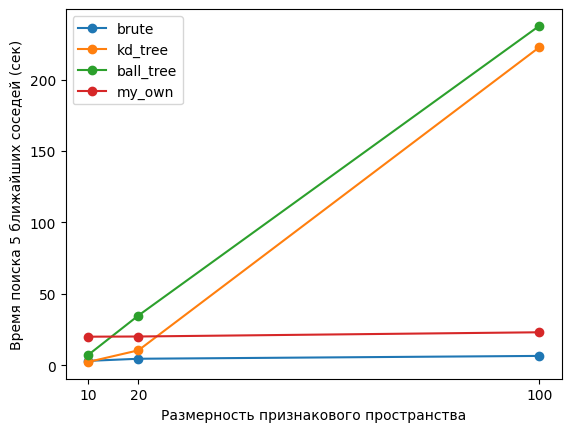

In [108]:
for index in results.index:
  plt.plot(results.loc[index], marker='o', label=index)

plt.legend()
plt.xticks([10, 20, 100])
plt.xlabel('Размерность признакового пространства')
plt.ylabel('Время поиска 5 ближайших соседей (сек)')
plt.show()

 # Эксперимент №2

In [109]:
cosine_results = pd.DataFrame(knn_cross_val_score(X_train, y_train, k_list=[i for i in range(1, 11)], score='accuracy', cv=None, strategy='brute', metric='cosine', weights=False, test_block_size=1000))

euclidean_results = pd.DataFrame(knn_cross_val_score(X_train, y_train, k_list=[i for i in range(1, 11)], score='accuracy',cv=None, strategy='brute', metric='euclidean', weights=False, test_block_size=1000))

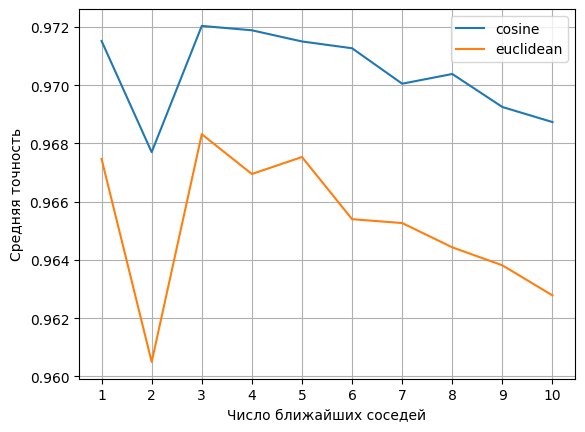

In [110]:
plt.plot(cosine_results.mean(), label='cosine')
plt.plot(euclidean_results.mean(), label='euclidean')
plt.legend()
plt.grid()
plt.xticks([i for i in range(1, 11)])
plt.xlabel('Число ближайших соседей')
plt.ylabel('Средняя точность')
plt.show()

In [111]:
stratagies = ['brute', 'my_own']
cv = kfold(X_train.shape[0], 3)
metrics = ['cosine', 'euclidean']
for metric in metrics:
  for strategy in stratagies:
    start_time = time.time()
    for train, valid in cv:
      model = KNNClassifier(k=3, strategy=strategy, metric=metric,
                            weights=False, test_block_size=5000)
      model.fit(X_train[train], y_train[train])
      neighbors = model.find_kneighbors(X_train[valid], return_distance=False)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Execution time of {strategy} algorithm with {metric}: {elapsed_time} s')
    print('===============================================')

Execution time of brute algorithm with cosine: 185.8024754524231 s
Execution time of my_own algorithm with cosine: 184.43483328819275 s
Execution time of brute algorithm with euclidean: 151.61472249031067 s
Execution time of my_own algorithm with euclidean: 189.45791697502136 s


# Эксперимент №3

Сравните взвешенный метод k ближайших соседей, где голос объекта равен 1/(distance + ε), где ε — 10−5
,
с методом без весов при тех же фолдах и параметрах.

In [112]:
weighted_cosine_results = pd.DataFrame(knn_cross_val_score(X_train, y_train, k_list=[i for i in range(1, 11)], score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=1000))


weighted_euclidean_results = pd.DataFrame(knn_cross_val_score(X_train, y_train, k_list=[i for i in range(1, 11)], score='accuracy', cv=None, strategy='brute', metric='euclidean', weights=True, test_block_size=1000))

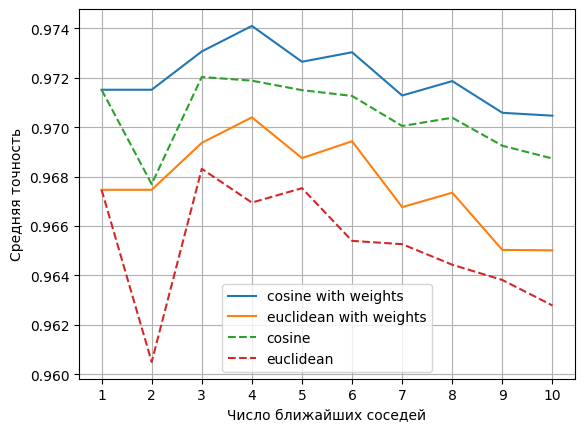

In [113]:
plt.plot(weighted_cosine_results.mean(), label='cosine with weights')
plt.plot(weighted_euclidean_results.mean(), label='euclidean with weights')
plt.plot(cosine_results.mean(), label='cosine', linestyle='--')
plt.plot(euclidean_results.mean(), label='euclidean', linestyle='--')
plt.legend()
plt.xticks([i for i in range(1, 11)])
plt.grid()
plt.xlabel('Число ближайших соседей')
plt.ylabel('Средняя точность')
plt.show()

In [114]:
stratagies = ['brute', 'my_own']
cv = kfold(X_train.shape[0], 3)
metrics = ['cosine', 'euclidean']
for metric in metrics:
  for strategy in stratagies:
    start_time = time.time()
    for train, valid in cv:
      model = KNNClassifier(k=3, strategy=strategy, metric=metric,
                            weights=True, test_block_size=1000)
      model.fit(X_train[train], y_train[train])
      neighbors = model.find_kneighbors(X_train[valid], return_distance=False)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Execution time of {strategy} algorithm with {metric}: {elapsed_time} s')
    print('===============================================')

Execution time of brute algorithm with cosine: 195.85593247413635 s
Execution time of my_own algorithm with cosine: 202.07894372940063 s
Execution time of brute algorithm with euclidean: 150.11171078681946 s
Execution time of my_own algorithm with euclidean: 193.5170545578003 s


# Эксперимент № 4

Примените лучший алгоритм к исходной обучающей и тестовой выборке. Подсчитайте точность. Сравните
с точностью по кросс-валидации. Сравните с указанной в интернете точностью лучших алгоритмов на
данной выборке. Выполните анализ ошибок. Для этого необходимо построить и проанализировать матрицу
ошибок (confusion matrix). Также визуализируйте несколько объектов из тестовой выборки, на которых
были допущены ошибки. Проанализируйте и указажите их общие черты.

cross val accuracy:  0.9741
time:  187.7228181362152
accuracy:  0.9752
time:  47.16434288024902
Start confusion matrix


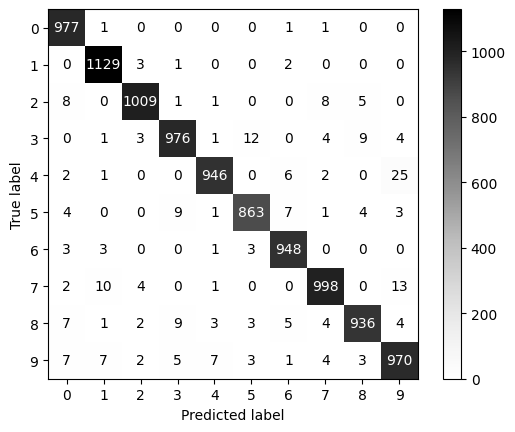

In [117]:
best_knn_model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=5000)
best_knn_model.fit(X_train, y_train)
start = time.time()
cross_val = knn_cross_val_score(X_train, y_train, k_list=[4], score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000)
end = time.time()
print('cross val accuracy: ', cross_val[4].mean())
print('time: ', end - start)
start = time.time()
y_pred = best_knn_model.predict(X_test)
start_accuracy = accuracy_score(y_test, y_pred)
print('accuracy: ', start_accuracy)
end = time.time()
print('time: ', end - start)
print('Start confusion matrix')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greys')
plt.show()

In [ ]:
for true, pred in [('4', '9'), ('3', '5'), ('7', '9'), ('7', '1')]:
  fig, ax = plt.subplots(1, 4)
  part = X_test[(y_test == true) & (y_pred == pred)]
  print(part.shape)
  for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(part[i].reshape(28, 28), cmap='Greys')
    ax[i].set_title(label=f'true: {true}, predicted: {pred}')
  fig.set_figwidth(12)
  fig.set_figheight(3)
  plt.show()

# Эксперимент №5

Выполните аугментацию обучающей выборки. Для этого нужно размножить ее с помощью поворотов,
смещений, морфологических операций и применений гауссовского фильтра. Разрешается использовать
библиотеки для работы с изображениями. Подберите по кросс-валидации с 3 фолдами параметры преобразований. Рассмотрите следующие параметры для преобразований и их комбинации:

In [7]:
augs = ['no augmentation', 'rotation' ,'shift', 'gauss', 'erode', 'dilate', 'opening', 'closing']
accuracy_list = []

In [9]:
best_knn_model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=5000)

In [62]:
indices = np.random.choice(X_train.shape[0], size=18000)
X_train_samples = X_train[indices]
y_train_samples = y_train[indices]

best_knn_model.fit(X_train_samples, y_train_samples)
cross_val = knn_cross_val_score(X_train_samples, y_train_samples, k_list=[4], score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000)
y_pred = best_knn_model.predict(X_test[:3000])
accuracy_sample = accuracy_score(y_test[:3000], y_pred)
accuracy_list += [accuracy_sample]
print('accuracy: ', accuracy_sample)
print('cross val: ', cross_val[4].mean())

accuracy:  0.9476666666666667
cross val:  0.9691666666666667


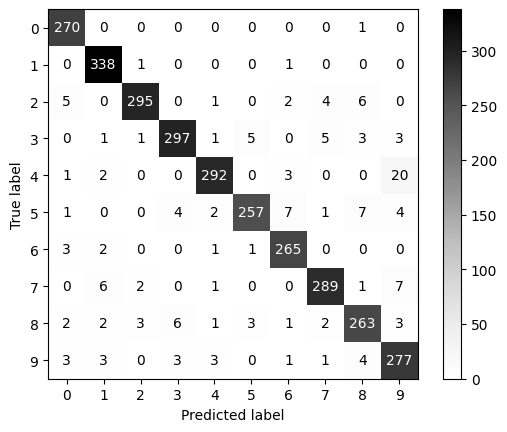

In [63]:
ConfusionMatrixDisplay.from_predictions(y_test[:3000], y_pred, cmap='Greys')
plt.show()

In [ ]:
best_accuracies = np.array(7)

# Поворот

In [57]:
def add_rotation(X, y, angle):
  X_rotated = scipy.ndimage.rotate(X.reshape((X.shape[0], 28, 28)), angle, axes=(1, 2), reshape=False).reshape((X.shape[0], 784))
  X_rotated_reverse = scipy.ndimage.rotate(X.reshape((X.shape[0], 28, 28)), -angle, axes=(1, 2), reshape=False).reshape((X.shape[0], 784))
  X_new = np.concatenate((X, X_rotated, X_rotated_reverse))
  y_new = np.concatenate((y, y, y))
  return X_new, y_new

In [60]:
def knn_cross_val_score_rotation(angle, X, y, k, score, cv, **kwargs):
  ans = []
  if cv is None:
      cv = kfold(X.shape[0], 3)

  for train, valid in cv:
    knn_model = KNNClassifier(k, **kwargs)
    X_train, y_train = add_rotation(X[train], y[train], angle)
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X[valid])
    if score == 'accuracy':
      ans_num = y[valid].shape[0]
      true_ans_num = np.sum(y[valid] == y_predict)
      ans += [true_ans_num / ans_num]
  return np.array(ans)

cross val with angle 5: 0.9709444444444445
time: 63.19140601158142
cross val with angle 10: 0.9737777777777777
time: 61.896493911743164
cross val with angle 15: 0.9730555555555555
time: 64.87453699111938
best parametr:  10
accuracy:  0.9636666666666667


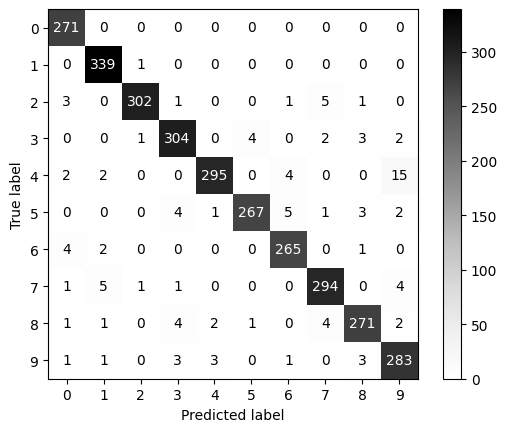

In [61]:
cross_val_rotation = np.zeros(3)
angles = [5, 10, 15]
for i in range(3):
  start = time.time()
  indices = np.random.choice(X_train.shape[0], size=18000)
  cross_val_rotation[i] = knn_cross_val_score_rotation(angles[i], X_train[indices], y_train[indices], k=4, score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000).mean()
  end = time.time()
  print(f'cross val with angle {angles[i]}: {cross_val_rotation[i]}\ntime: {end-start}')

best_angle = angles[np.argmax(cross_val_rotation)]

print('best parametr: ', best_angle)

indices = np.random.choice(X_train.shape[0], size=18000)
X_train_samples = X_train[indices]
y_train_samples = y_train[indices]

best_knn_model.fit(*add_rotation(X_train_samples, y_train_samples, best_angle))
y_pred = best_knn_model.predict(X_test[:3000])
print("accuracy: ", accuracy_score(y_test[:3000], y_pred))
accuracy_list += [accuracy_score(y_test[:3000], y_pred)]

ConfusionMatrixDisplay.from_predictions(y_test[:3000], y_pred, cmap='Greys')
plt.show()


# Сдвиг

In [27]:
def add_shift(X, y, shift):
  indices = np.array_split(np.arange(X.shape[0]), 4)
  X_new = X
  y_new = y
  signs = [(1, 1), (-1, 1), (1, -1), (-1, -1)]
  for i in range(4):
    X_new = np.concatenate((X_new, scipy.ndimage.shift(X[indices[i]].reshape((X[indices[i]].shape[0], 28, 28)), (0, shift*signs[i][0], shift*signs[i][1])).reshape((X[indices[i]].shape[0], 784))))
    y_new = np.concatenate((y_new, y[indices[i]]))
  return X_new, y_new

In [28]:
def knn_cross_val_score_shift(shift, X, y, k, score, cv, **kwargs):
  ans = []
  if cv is None:
      cv = kfold(X.shape[0], 3)

  for train, valid in cv:
    knn_model = KNNClassifier(k, **kwargs)
    X_train, y_train = add_shift(X[train], y[train], shift)
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X[valid])
    if score == 'accuracy':
      ans_num = y[valid].shape[0]
      true_ans_num = np.sum(y[valid] == y_predict)
      ans += [true_ans_num / ans_num]
  return np.array(ans)

In [29]:
cross_val_shift = np.zeros(3)
shifts = [1, 2, 3]
for i in range(3):
  indices = np.random.choice(X_train.shape[0], size=18000)
  X_train_samples = X_train[indices]
  y_train_samples = y_train[indices]

  start = time.time()
  cross_val_shift[i] = knn_cross_val_score_shift(shifts[i], X_train_samples, y_train_samples, k=4, score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000).mean()
  print(f'cross val with shift {shifts[i]}: ', cross_val_shift[i])
  end = time.time()
  print('time: ', end-start)

cross val with shift 1:  0.9715555555555556
time:  52.56094980239868
cross val with shift 2:  0.9685
time:  48.63497018814087
cross val with shift 3:  0.9690555555555554
time:  46.15315341949463


In [30]:
best_shift = shifts[np.argmax(cross_val_shift)]

In [26]:
uniq, counts = np.unique(y_train[:18000], return_counts=True)
uniq, counts

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([1783, 2051, 1740, 1883, 1747, 1587, 1771, 1900, 1732, 1806]))

In [31]:
best_knn_model.fit(*add_shift(X_train[:18000], y_train[:18000], best_shift))
y_pred = best_knn_model.predict(X_test[:3000])
print("accuracy: ", accuracy_score(y_test[:3000], y_pred))
accuracy_list += [accuracy_score(y_test[:3000], y_pred)]

accuracy:  0.9533333333333334


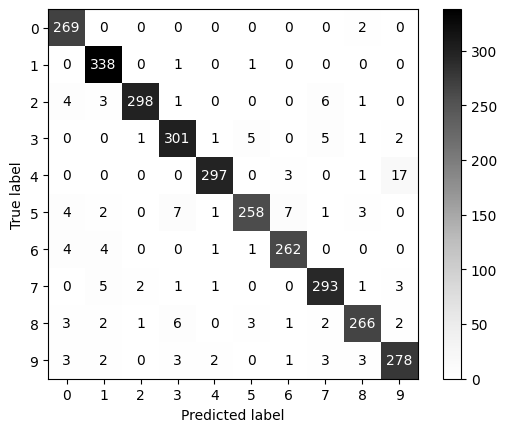

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test[:3000], y_pred, cmap='Greys')
plt.show()

# Гауссовский фильтр

In [20]:
def add_gauss(X, y, deviation):
  X_blur = cv.GaussianBlur(X.reshape((X.shape[0], 28, 28)), (25, 25), deviation)
  X_new = np.concatenate((X, X_blur.reshape((X.shape[0], 784))))
  y_new = np.concatenate((y, y))
  return X_new, y_new

In [21]:
def knn_cross_val_score_gauss(angle, X, y, k, score, cv, **kwargs):
  ans = []
  if cv is None:
      cv = kfold(X.shape[0], 3)

  for train, valid in cv:
    knn_model = KNNClassifier(k, **kwargs)
    X_train, y_train = add_gauss(X[train], y[train], angle)
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X[valid])
    if score == 'accuracy':
      ans_num = y[valid].shape[0]
      true_ans_num = np.sum(y[valid] == y_predict)
      ans += [true_ans_num / ans_num]
  return np.array(ans)


In [33]:
cross_val_gauss = np.zeros(3)
deviations = [0.5, 1, 1.5]
for i in range(3):
  indices = np.random.choice(X_train.shape[0], size=18000)

  X_train_samples = X_train[indices]
  y_train_samples = y_train[indices]

  start = time.time()
  cross_val_gauss[i] = knn_cross_val_score_gauss(deviations[i], X_train_samples, y_train_samples, k=4, score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000).mean()
  end = time.time()
  print(f'cross val with deviation {deviations[i]}: ', cross_val_gauss[i])
  print('time: ', end - start)

cross val with deviation 0.5:  0.9662777777777777
time:  31.77210021018982
cross val with deviation 1:  0.9622222222222222
time:  34.81092357635498
cross val with deviation 1.5:  0.9633888888888889
time:  37.413785457611084


accuracy:  0.951


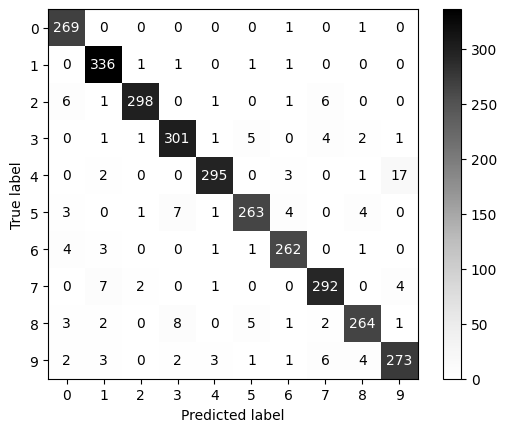

In [34]:
best_deviation = deviations[np.argmax(cross_val_gauss)]
best_knn_model.fit(*add_gauss(X_train[:18000], y_train[:18000], best_deviation))
y_pred = best_knn_model.predict(X_test[:3000])
print("accuracy: ", accuracy_score(y_test[:3000], y_pred))
accuracy_list += [accuracy_score(y_test[:3000], y_pred)]
ConfusionMatrixDisplay.from_predictions(y_test[:3000], y_pred, cmap='Greys')
plt.show()

# Эрозия

In [35]:
def add_erode(X, y):
  kernel = np.ones((2,2),np.uint8)
  X_er = cv.erode(X.reshape((X.shape[0], 28, 28)), kernel, iterations = 1)
  X_new = np.concatenate((X, X_er.reshape((X.shape[0], 784))))
  y_new = np.concatenate((y, y))
  return X_new, y_new

In [36]:
def knn_cross_val_score_erode(X, y, k, score, cv, **kwargs):
  ans = []
  if cv is None:
      cv = kfold(X.shape[0], 3)

  for train, valid in cv:
    knn_model = KNNClassifier(k, **kwargs)
    X_train, y_train = add_erode(X[train], y[train])
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X[valid])
    if score == 'accuracy':
      ans_num = y[valid].shape[0]
      true_ans_num = np.sum(y[valid] == y_predict)
      ans += [true_ans_num / ans_num]
  return np.array(ans)


In [37]:
indices = np.random.choice(X_train.shape[0], size=18000)
X_train_samples = X_train[indices]
y_train_samples = y_train[indices]

start = time.time()
cross_val_erode = knn_cross_val_score_erode(X_train_samples, y_train_samples, k=4, score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000)
end = time.time()
print(f'cross val: ', cross_val_erode.mean())
print('time: ', end - start)

cross val:  0.9687222222222222
time:  31.64492630958557


accuracy:  0.9516666666666667


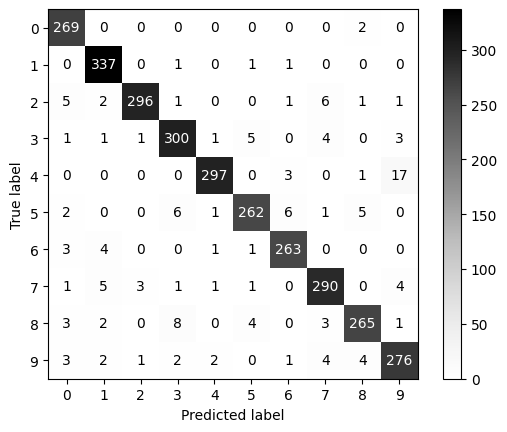

In [38]:
best_knn_model.fit(*add_erode(X_train[:18000], y_train[:18000]))
y_pred = best_knn_model.predict(X_test[:3000])
print("accuracy: ", accuracy_score(y_test[:3000], y_pred))
accuracy_list += [accuracy_score(y_test[:3000], y_pred)]
ConfusionMatrixDisplay.from_predictions(y_test[:3000], y_pred, cmap='Greys')
plt.show()

# Дилатация

In [39]:
def add_dilate(X, y):
  kernel = np.ones((2,2),np.uint8)
  X_dil = cv.dilate(X.reshape((X.shape[0], 28, 28)), kernel, iterations = 1)
  X_new = np.concatenate((X, X_dil.reshape((X.shape[0], 784))))
  y_new = np.concatenate((y, y))
  return X_new, y_new

In [40]:
def knn_cross_val_score_dilate(X, y, k, score, cv, **kwargs):
  ans = []
  if cv is None:
      cv = kfold(X.shape[0], 3)

  for train, valid in cv:
    knn_model = KNNClassifier(k, **kwargs)
    X_train, y_train = add_dilate(X[train], y[train])
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X[valid])
    if score == 'accuracy':
      ans_num = y[valid].shape[0]
      true_ans_num = np.sum(y[valid] == y_predict)
      ans += [true_ans_num / ans_num]
  return np.array(ans)

In [41]:
indices = np.random.choice(X_train.shape[0], size=18000)
X_train_samples = X_train[indices]
y_train_samples = y_train[indices]
start = time.time()
cross_val_dil = knn_cross_val_score_dilate(X_train_samples, y_train_samples, k=4, score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000)
end = time.time()
print(f'cross val: ', cross_val_dil.mean())
print('time: ', end - start)

cross val:  0.9646666666666667
time:  31.335936546325684


accuracy:  0.9496666666666667


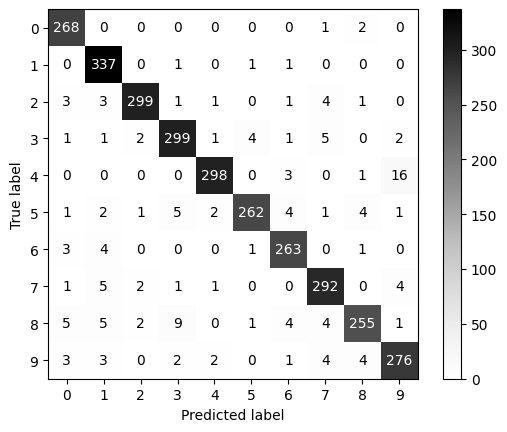

In [42]:
best_knn_model.fit(*add_dilate(X_train[:18000], y_train[:18000]))
y_pred = best_knn_model.predict(X_test[:3000])
print("accuracy: ", accuracy_score(y_test[:3000], y_pred))
accuracy_list += [accuracy_score(y_test[:3000], y_pred)]
ConfusionMatrixDisplay.from_predictions(y_test[:3000], y_pred, cmap='Greys')
plt.show()

# Открытие

In [43]:
def add_opening(X, y):
  kernel = np.ones((2,2),np.uint8)
  X_dil = cv.morphologyEx(X.reshape((X.shape[0], 28, 28)), cv.MORPH_OPEN, kernel)
  X_new = np.concatenate((X, X_dil.reshape((X.shape[0], 784))))
  y_new = np.concatenate((y, y))
  return X_new, y_new

In [44]:
def knn_cross_val_score_opening(X, y, k, score, cv, **kwargs):
  ans = []
  if cv is None:
      cv = kfold(X.shape[0], 3)

  for train, valid in cv:
    knn_model = KNNClassifier(k, **kwargs)
    X_train, y_train = add_opening(X[train], y[train])
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X[valid])
    if score == 'accuracy':
      ans_num = y[valid].shape[0]
      true_ans_num = np.sum(y[valid] == y_predict)
      ans += [true_ans_num / ans_num]
  return np.array(ans)

In [45]:
indices = np.random.choice(X_train.shape[0], size=18000)
X_train_samples = X_train[indices]
y_train_samples = y_train[indices]

start = time.time()
cross_val_op = knn_cross_val_score_opening(X_train_samples, y_train_samples, k=4, score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000).mean()
end = time.time()

print(f'cross val: ', cross_val_op.mean())
print('time: ', end - start)

cross val:  0.9666111111111112
time:  31.445932865142822


accuracy:  0.949


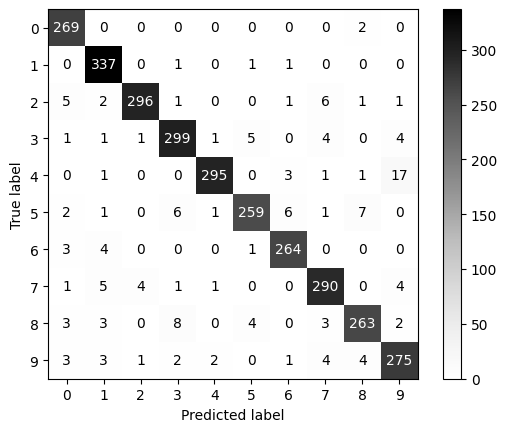

In [46]:
best_knn_model.fit(*add_opening(X_train[:18000], y_train[:18000]))
y_pred = best_knn_model.predict(X_test[:3000])
print("accuracy: ", accuracy_score(y_test[:3000], y_pred))
accuracy_list += [accuracy_score(y_test[:3000], y_pred)]
ConfusionMatrixDisplay.from_predictions(y_test[:3000], y_pred, cmap='Greys')
plt.show()

# Закрытие

In [47]:
def add_closing(X, y):
  kernel = np.ones((2,2),np.uint8)
  X_dil = cv.morphologyEx(X.reshape((X.shape[0], 28, 28)), cv.MORPH_CLOSE, kernel)
  X_new = np.concatenate((X, X_dil.reshape((X.shape[0], 784))))
  y_new = np.concatenate((y, y))
  return X_new, y_new

In [48]:
def knn_cross_val_score_closing(X, y, k, score, cv, **kwargs):
  ans = []
  if cv is None:
      cv = kfold(X.shape[0], 3)

  for train, valid in cv:
    knn_model = KNNClassifier(k, **kwargs)
    X_train, y_train = add_closing(X[train], y[train])
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X[valid])
    if score == 'accuracy':
      ans_num = y[valid].shape[0]
      true_ans_num = np.sum(y[valid] == y_predict)
      ans += [true_ans_num / ans_num]
  return np.array(ans)

In [49]:
indices = np.random.choice(X_train.shape[0], size=18000)
X_train_samples = X_train[indices]
y_train_samples = y_train[indices]

start = time.time()
cross_val_cl = knn_cross_val_score_closing(X_train_samples, y_train_samples, k=4, score='accuracy', cv=None, strategy='brute', metric='cosine', weights=True, test_block_size=5000)
end = time.time()
print(f'cross val: ', cross_val_cl.mean())
print('time: ', end - start)

cross val:  0.9429444444444445
time:  40.313196420669556


accuracy:  0.9266666666666666


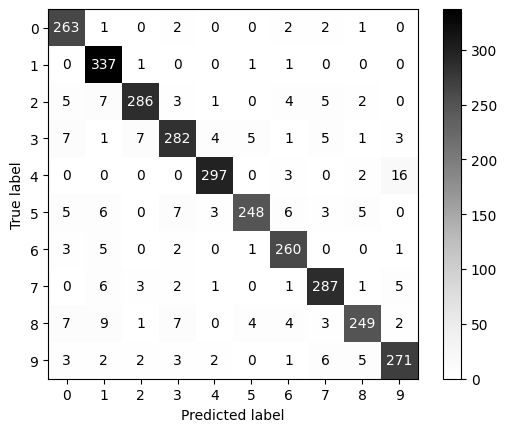

In [50]:
best_knn_model.fit(*add_closing(X_train[:18000], y_train[:18000]))
y_pred = best_knn_model.predict(X_test[:3000])
print("accuracy: ", accuracy_score(y_test[:3000], y_pred))
accuracy_list += [accuracy_score(y_test[:3000], y_pred)]
ConfusionMatrixDisplay.from_predictions(y_test[:3000], y_pred, cmap='Greys')
plt.show()

Лучшие преобразования: Гаусс 0.5, поворот 5, сдвиг 1

accuracy:  0.9788
time:  430.0984845161438


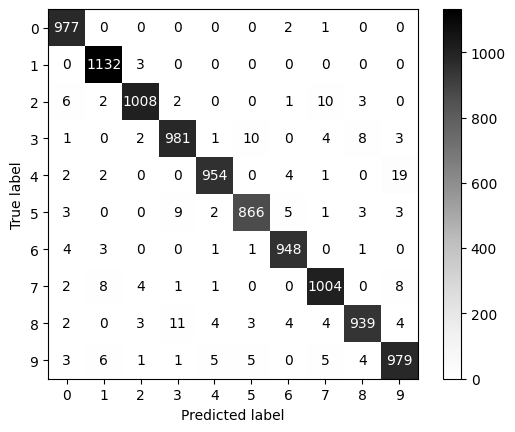

In [65]:
start = time.time()
X_train_aug, y_train_aug = add_shift(X_train, y_train, 1)
X_train_aug, y_train_aug = add_rotation(X_train_aug, y_train_aug, 5)
best_knn_model.fit(X_train_aug, y_train_aug)
y_pred = best_knn_model.predict(X_test)
end = time.time()
print('accuracy: ', accuracy_score(y_test, y_pred))
print('time: ', end - start)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greys')
plt.show()

In [ ]:
start = time.time()
X_train_aug, y_train_aug = add_gauss(X_train, y_train, 0.5)
X_train_aug = add_rotation(X_train_aug, 5).reshape(-1, 784)
y_train_aug = y = np.stack((y_train_aug, y_train_aug, y_train_aug), axis=1).reshape(-1)
print(X_train_aug.shape)
best_knn_model.fit(X_train_aug, y_train_aug)
y_pred = best_knn_model.predict(X_test)
end = time.time()
print('accuracy: ', accuracy_score(y_test, y_pred))
print('time: ', end - start)

# Эксперимент 6

Реализуйте описанный выше алгоритм, основанный на преобразовании объектов тестовой выборки. Проверьте то же самое множество параметров, что и в предыдущем пункте. Проанализируйте как изменилась
матрица ошибок, какие ошибки алгоритма помогает исправить каждое преобразование. Качественно сравните два подхода (5 и 6 пункты) между собой.
Замечание. В рамках данного эксперимента подразумевается обучение модели на оригинальном датасете,
преобразования объектов тестовой выборки, применение модели к преобразованным копиям изображения
из тестовой выборки и получение результата путем голосования среди преобразованных объектов.

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greys')
plt.show()

In [82]:
def voting(y, n_params, y_true):
  y = y.reshape((-1, n_params), order='F')
  unique_targets = np.unique(y)
  weights = np.ones_like(y)
  weighted_targets = np.array([])
  for index in range(len(unique_targets)):
      target = unique_targets[index]
      only_target = np.where(y == target, 1, 0)
      weighted_target = np.sum(weights * only_target, axis=1)
      weighted_target = weighted_target.reshape((-1, 1))
      if index == 0:
          weighted_targets = weighted_target
      else:
          weighted_targets = np.hstack((weighted_targets, weighted_target))
  max_indices = np.argmax(weighted_targets, axis=1)
  return unique_targets[max_indices]


In [85]:
def augmentations_score(model, X, y):
  augs = ['rotation' ,'shift', 'gauss', 'erode', 'dilate', 'opening', 'closing']
  funcs = [add_rotation, add_shift, add_gauss, add_erode, add_dilate, add_opening, add_closing]
  params = [[5, 10, 15], [1, 2, 3], [0.5, 1, 1.5], [None], [None], [None], [None]]
  extention_ratio = [3, 2, 2, 2, 2, 2, 2]
  best_accuracies = np.zeros(len(augs))
  for i, aug in enumerate(augs):
    accuracies = []
    for param in params[i]:
      if param is None:
        X_test_aug, _ = funcs[i](X, y)
      else:
        X_test_aug, _ = funcs[i](X, y, param)
      y_pred_aug = model.predict(X_test_aug)
      y_pred = voting(y_pred_aug, extention_ratio[i], y)
      print(f'accuracy for {aug} with parametr {param}: ', accuracy_score(y, y_pred))
      accuracies += [accuracy_score(y, y_pred)]
      print(f'{aug}, {param}')
      ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Greys')
      plt.show()
    best_accuracies[i] = max(accuracies)


  return best_accuracies

accuracy for rotation with parametr 5:  0.9773
rotation, 5


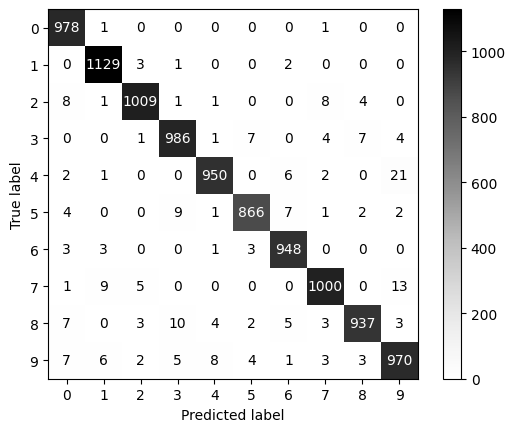

accuracy for rotation with parametr 10:  0.9759
rotation, 10


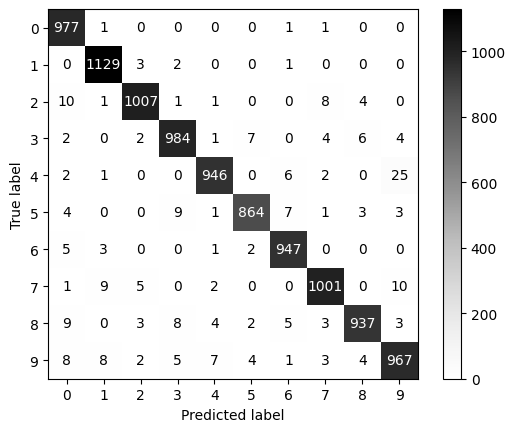

accuracy for rotation with parametr 15:  0.9752
rotation, 15


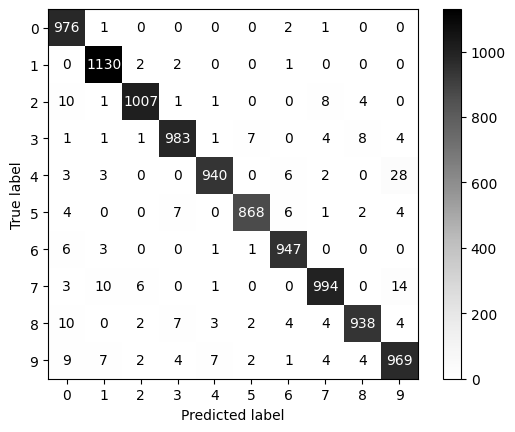

accuracy for shift with parametr 1:  0.9433
shift, 1


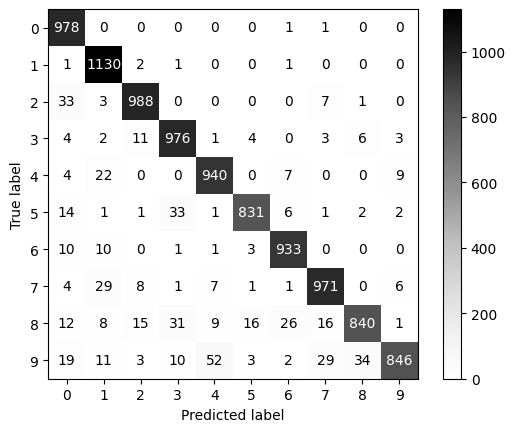

accuracy for shift with parametr 2:  0.7732
shift, 2


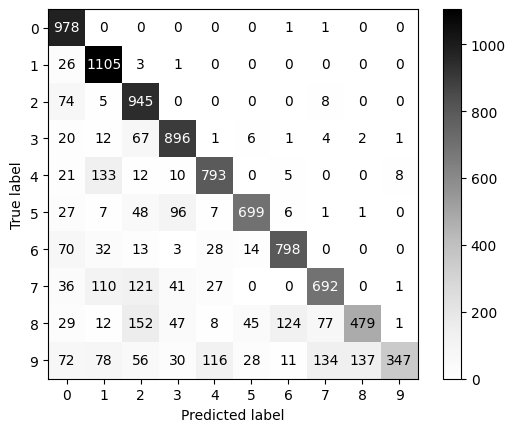

accuracy for shift with parametr 3:  0.6294
shift, 3


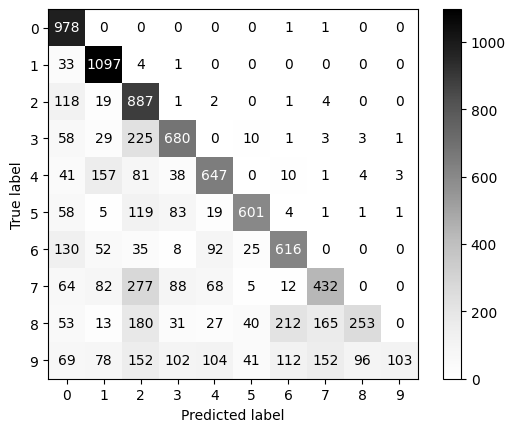

accuracy for gauss with parametr 0.5:  0.9724
gauss, 0.5


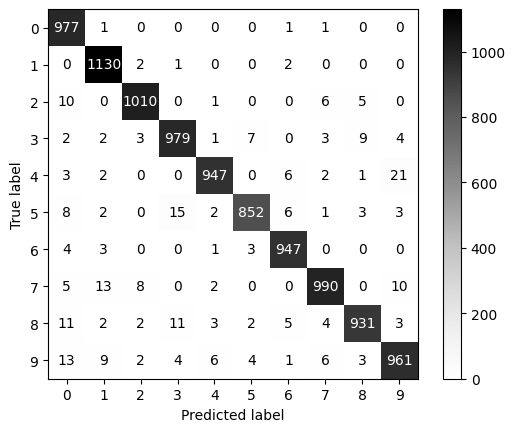

accuracy for gauss with parametr 1:  0.7933
gauss, 1


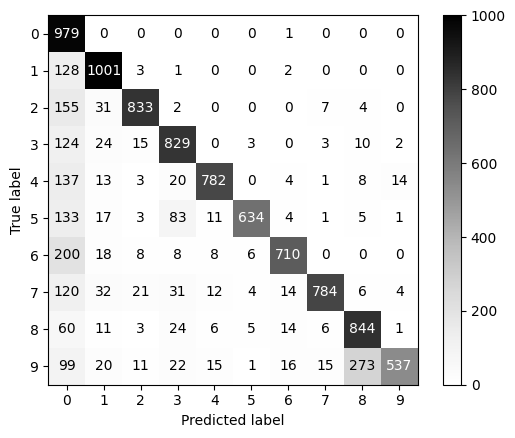

accuracy for gauss with parametr 1.5:  0.7177
gauss, 1.5


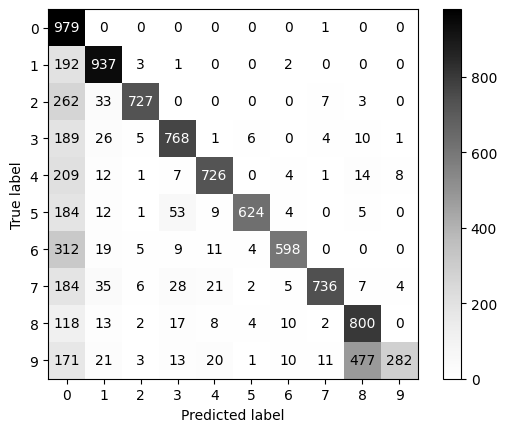

accuracy for erode with parametr None:  0.6731
erode, None


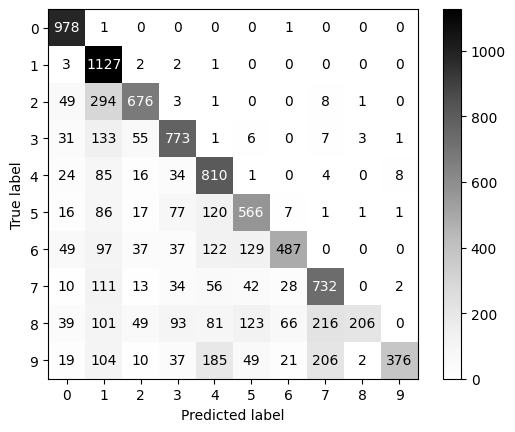

accuracy for dilate with parametr None:  0.7198
dilate, None


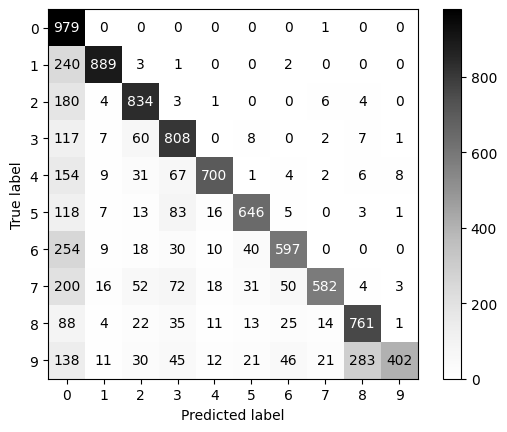

accuracy for opening with parametr None:  0.5459
opening, None


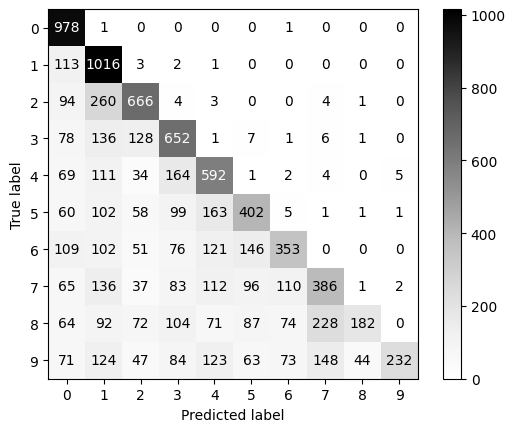

accuracy for closing with parametr None:  0.5502
closing, None


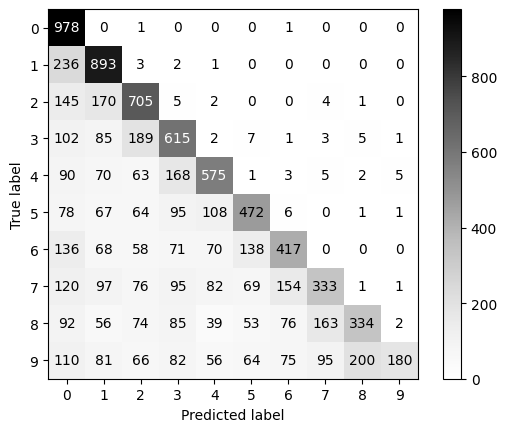

<Axes: >

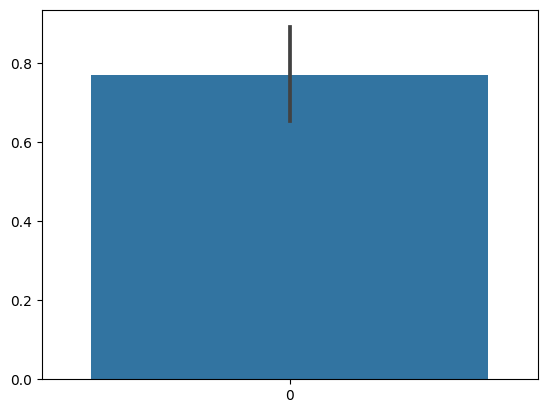

In [86]:
knn_model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=5000)
knn_model.fit(X_train, y_train)
results = augmentations_score(knn_model, X_test, y_test)

In [91]:
np.insert(results, 0, 0.9752)

array([0.9752, 0.9773, 0.9433, 0.9724, 0.6731, 0.7198, 0.5459, 0.5502])

In [95]:
X_new_test, _ = add_rotation(*add_shift(X_test, y_test, 1), 5)

In [96]:
y_pred = voting(knn_model.predict(X_new_test), 6, y_test)
print('final accuracy: ', accuracy_score(y_test, y_pred))

final accuracy:  0.9593
